In [1]:
%matplotlib inline
import scipy as sp
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['legend.fancybox'] = False

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import model_selection, linear_model, svm, gaussian_process
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score


### function defs

In [2]:
# fast hack for linear regression
def brainballbaby_linreg(x_train, y_train, x_test, y_test, feat_cols, age_range=None):
    age_inds_train = get_age_inds(y_train, age_range)
    age_inds_test = get_age_inds(y_test, age_range)
    
    # Create linear regression object
    regr = linear_model.LinearRegression()
        
    # Train the model using the training sets
    regr.fit(x_train[age_inds_train,:][:,feat_cols], y_train[age_inds_train])
    print('Training R2 score: %.2f' % r2_score(y_train[age_inds_train], regr.predict(x_train[age_inds_train,:][:,feat_cols])))
    
    # Make prediction, print & plot stats
    predict_on_testset(regr, x_test[age_inds_test,:][:,feat_cols], y_test[age_inds_test])

    
def get_preproc_datasets(baby_feat, baby_pma, baby_id, org_feat_stacked, org_age_stacked, org_id_stacked, 
                         train_set='baby', feat_cols=None, age_range=None):

    age_inds_baby = get_age_inds(baby_pma, age_range)
    age_inds_org = get_age_inds(org_age_stacked, age_range)
    
    if feat_cols is None:
        feat_cols = range(baby_feat.shape[1])
    
    if train_set is 'baby':
        train_x = baby_feat[age_inds_baby,:][:,feat_cols]
        train_y = baby_pma[age_inds_baby]
        train_id = baby_id[age_inds_baby]
        test_x = org_feat_stacked[age_inds_org,:][:,feat_cols]
        test_y = org_age_stacked[age_inds_org]
        test_id = org_id_stacked[age_inds_org]
        
    elif train_set is 'organoid':
        train_x = org_feat_stacked[age_inds_org,:][:,feat_cols]
        train_y = org_age_stacked[age_inds_org]
        train_id = org_id_stacked[age_inds_org]
#         test_x = baby_feat[age_inds_baby,:][:,feat_cols]
#         test_y = baby_pma[age_inds_baby]
#         test_id = baby_id[age_inds_baby]
        test_x = baby_feat[:,feat_cols]
        test_y = baby_pma
        test_id = baby_id
    
    else: 
        print('BABY OR BRAINBALL??? \n(baby or organoid)')
        return None,None,None,None,None,None

    return train_x, train_y, train_id, test_x, test_y, test_id
    
    
def predict_on_testset(model, x_test, y_test, figsize=(6,3)):
    y_pred = model.predict(x_test)
    
    # get line of best fit between test and predicted
    pparams = np.polyfit(y_test, y_pred, deg=1)
    
    plt.figure(figsize=figsize)
    # plot prediction mean & std
    plot_mean_pred(model.predict(x_test), y_test)
    plt.plot(y_test, y_pred, '.', alpha=0.5)
    YL = plt.ylim()
    plt.plot(y_test, y_test, 'r-', label='Perfect Prediction', alpha=0.5)
    #plt.plot(y_test, y_test*pparams[0]+pparams[1], 'k-', label='True vs. Predict')
    plt.xlabel('Actual Age (Weeks)')
    plt.ylabel('Predicted Age (Weeks)')
    plt.ylim(YL);
    plt.legend()
    
    print('---')
    # The mean squared error
    print("Mean squared error: %.3f" % mean_squared_error(y_test, y_pred))
    # R2 score: 1 is perfect prediction
    print('R2 score: %.3f' % r2_score(y_test, y_pred))
#     # Explained variance
#     print('Variance explained: %.3f' % r2_score(y_test, y_pred))
    # Correlation
    print('Correlation Coef: %.2f, P-Value: %.5f' % sp.stats.pearsonr(y_test, y_pred))
    

def get_age_inds(age_vec, age_range):
    # return indices that satisfy the required age range
    if age_range is None:
        age_inds = np.arange(len(age_vec))
    else:
        age_inds = np.logical_and(age_vec>age_range[0], age_vec<age_range[1])

    return age_inds

def print_model_weights(model, feat_names):    
    print('------- Feature Weights: ------')
    print('Constant: : %.5f' %model.intercept_)
    for i in range(len(feat_names)):
        print(feat_names[i] +': %.5f' %model.coef_[i])

def plot_mean_pred(pred_y, test_y):
    ages = np.unique(test_y)
    pred_mean = np.zeros_like(ages)
    pred_std = np.zeros_like(ages)
    sig_x = []
    for ind, age in enumerate(ages):
        if sp.stats.ttest_1samp(pred_y[np.where(test_y == age)[0]], age)[1]>0.05:
            sig_x.append(age)
        
        pred_mean[ind] = np.mean(pred_y[np.where(test_y == age)[0]])
        pred_std[ind] = np.std(pred_y[np.where(test_y == age)[0]])
    #    pred_std[ind] = sp.stats.sem(pred_y[np.where(test_y == age)[0]])*2

    plt.fill_between(ages, pred_mean-pred_std, pred_mean+pred_std, facecolor=[0,0,0,0.2], edgecolor=[0,0,0,0.2])
    plt.plot(ages, pred_mean, 'k-', label='Mean Prediction')
#    plt.plot(test_y, test_y, 'r-')
    plt.plot(sig_x, np.ones_like(sig_x)*plt.ylim()[1], 'k*')
    plt.xlabel('Actual Age (Weeks)')
    plt.ylabel('Predicted Age (Weeks)')

### load data & preprocess

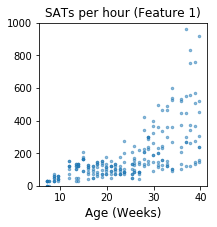

In [6]:
fig_saveout = '/Users/rdgao/Dropbox/Research/Reports/2018 - CorticoidOscillation/CorticoidFigs/figures/raw_pdfs/'

# organoid data
org_feat_file = '/Users/rdgao/Documents/data/Muotri/Pri_Corticoids/ctc_EMAfeatures.mat'
org_data = io.loadmat(org_feat_file, squeeze_me=True)
org_feat = org_data['ctc_EMAfeatures']
org_age = org_data['dayVec']

# stack organoid features, original dimensions are (session x wells x feature)
org_feat_stacked = np.reshape(org_feat, (np.prod(org_feat.shape[:2]), org_feat.shape[2]))
# drop rows with nans in the feature
clean_inds = np.where(~np.isnan(org_feat_stacked).any(axis=1))[0]
org_feat_stacked = org_feat_stacked[clean_inds,:]
org_age_stacked = np.repeat(org_age, org_feat.shape[1])[clean_inds]
org_id_stacked = np.reshape(np.matmul(np.ones((org_feat.shape[0],1)), np.expand_dims(np.arange(8),0)), -1)[clean_inds]

# baby data
baby_feat_file = '/Users/rdgao/Documents/data/Muotri/InfantEEGFeatures/preterm_features.mat'
baby_data = sp.io.loadmat(baby_feat_file, squeeze_me=True)
baby_data.keys()
baby_feat = baby_data['features_fullepoch']

# split age array into columns
baby_id, baby_pma, baby_ema = baby_data['age'].T

# only want certain columns of features
feat_cols = np.array([6,7,8,9,10,11,12,13,14,19,20,21,22])
feat_names = ['SATs per hour',
'RMS SAT duration',
'SAT duration (50%)',
'SAT duration (5%)',
'SAT duration (95%)',
'RMS Inter-SAT Duration',
'Inter-SAT duration (50%)',
'Inter-SAT duration (5%)',
'Inter-SAT duration (95%)',
'Relative Delta Power',
'Relative Theta Power',
'Relative Alpha Power',
'Relative Beta Power']

plt.figure(figsize=(3,3))
feat_ind = 0
pparams = np.polyfit(baby_pma, baby_feat[:,feat_cols[feat_ind]], deg=1)
plt.plot(org_age_stacked, org_feat_stacked[:,feat_cols[feat_ind]], '.', ms=5,alpha=0.5,label='Organoid');
# plt.plot(baby_pma, baby_feat[:,feat_cols[feat_ind]],'.k', ms=5, alpha=0.2, label='Neonate');
# plt.plot([25., 38.], np.array([25., 38.])*pparams[0]+pparams[1], 'r-', lw=3)
plt.xlabel('Age (Weeks)', fontsize=12)
plt.title(feat_names[feat_ind] + ' (Feature %i)'%(feat_ind+1), fontsize=12)
plt.ylim([0, 1000])
#plt.legend(fontsize=12)
#plt.xlim([24, 40])
#plt.savefig(fig_saveout + '6_' + feat_names[feat_ind] + '.pdf', bbox_inches = 'tight')
plt.savefig('/Users/rdgao/Dropbox/Research/Reports/2018 - KIBMTalk - CorticoidOscillation/' + '6_' + feat_names[feat_ind] + '.pdf', bbox_inches = 'tight')

In [10]:
baby_id.shape

(567,)

### measuring baby-organoid feature correlations

Text(0.5,1,'Infant-Organoid Feature Corr.')

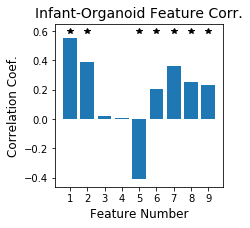

In [12]:
rhos = []
pvs = []
age_range = (1,40)
train_set = 'organoid'
# define training data & id
train_x, train_y, train_id, test_x, test_y, test_id = get_preproc_datasets(
    baby_feat, baby_pma, baby_id, 
    org_feat_stacked, org_age_stacked, org_id_stacked,
    train_set=train_set, feat_cols=feat_cols[:-4], age_range=age_range)


for ind,feat_ind in enumerate(feat_cols[:-4]):
    linreg = linear_model.LinearRegression()
    linreg.fit(train_y.reshape(-1,1), train_x[:,ind])
    feat_pred = linreg.predict(test_y.reshape(-1,1))    
    rho_, pv_ = sp.stats.pearsonr(feat_pred, test_x[:,ind])
    
    rhos.append(rho_)
    pvs.append(pv_)

plt.figure(figsize=(3,3))
plt.bar(1+np.arange(len(rhos)), np.array(rhos))
tmp = [i+1 for i,pv in enumerate(pvs) if pv<0.05]
plt.plot(tmp, len(tmp)*[0.6], 'k*')
plt.xticks(np.arange(len(rhos))+1)
plt.xlabel('Feature Number', fontsize=12)
plt.ylabel('Correlation Coef.', fontsize=12)
plt.title('Infant-Organoid Feature Corr.', fontsize=14)

### visualize all features

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


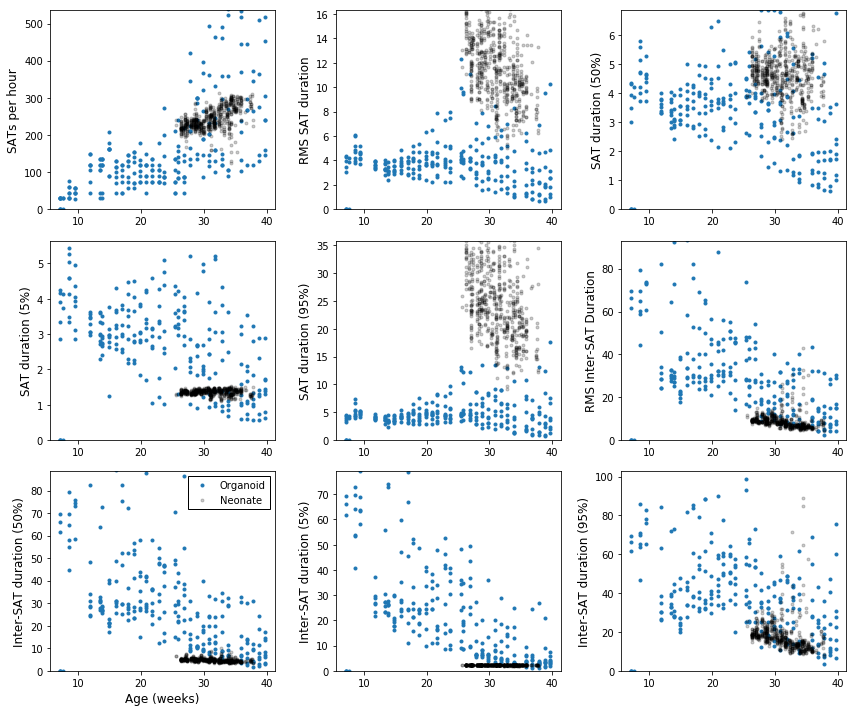

In [20]:
plt.figure(figsize=(12,10))
for ind, ft in enumerate(feat_cols[:-4]):
    plt.subplot(3,3,ind+1)
    
#     plt.plot(org_feat_stacked[:,ft], org_age_stacked, '.')
#     plt.plot(baby_feat[:,ft], baby_pma, '.k', alpha=0.2);
#     plt.ylim([25,38])
#     plt.xlim([0, np.max([np.percentile(org_feat_stacked[:,ft], 95), np.percentile(baby_feat[:,ft], 95)])])
#     plt.ylabel('Age (weeks)')
    
    plt.plot(org_age_stacked,org_feat_stacked[:,ft], '.', label='Organoid')
    plt.plot(baby_pma, baby_feat[:,ft],'.k', alpha=0.2, label='Neonate');
#    plt.xlim([25,38])
    plt.ylim([0, np.max([np.percentile(org_feat_stacked[:,ft], 95), np.percentile(baby_feat[:,ft], 95)])])    
    plt.ylabel(feat_names[ind], fontsize=12)
    
plt.subplot(3,3,7)
plt.xlabel('Age (weeks)', fontsize=12)
plt.legend(fancybox=False, shadow=False, framealpha=1, edgecolor='k')
plt.tight_layout()
plt.savefig(fig_saveout + 'supp_all_features.pdf', bbox_inches = 'tight')

### resampled correlation & linear fits

In [21]:
# setting up data
train_set = 'baby'
feat_subset = range(len(feat_names)-4)
#feat_subset = [0,8]
print('Training on: ' + train_set)

# define training data & id
baby_x, baby_y, baby_id, org_x, org_y, org_id = get_preproc_datasets(
    baby_feat, baby_pma, baby_id, 
    org_feat_stacked, org_age_stacked, org_id_stacked,
    train_set=train_set, feat_cols=feat_cols[feat_subset], age_range=(25,38))

N_split = 100
leave_p = 0.5
# cross-validation iterator
cv_splitter_baby = model_selection.GroupShuffleSplit(
    n_splits=N_split, test_size=leave_p).split(baby_x, baby_y, baby_id)

cv_splitter_org = model_selection.GroupShuffleSplit(
    n_splits=N_split, test_size=leave_p).split(org_x, org_y, org_id)

params_baby = np.zeros((N_split, 3, len(feat_subset)))
params_org = np.zeros((N_split, 3, len(feat_subset)))

for ind, cv in enumerate(cv_splitter_baby):
    # gotta put feature loop inside the CV loop because generator exhausts itself
    for feat in feat_subset:
        params_baby[ind, :2, feat] = np.polyfit(baby_y[cv[0]], baby_x[cv[0],feat], deg=1)        
        params_baby[ind, 2, feat] = sp.stats.pearsonr(baby_y[cv[0]],baby_x[cv[0],feat])[0]

for ind, cv in enumerate(cv_splitter_org):
    for feat in feat_subset:
        params_org[ind, :2, feat] = np.polyfit(org_y[cv[0]], org_x[cv[0],feat], deg=1)
        params_org[ind, 2, feat] = sp.stats.pearsonr(org_y[cv[0]],org_x[cv[0],feat])[0]

Training on: baby


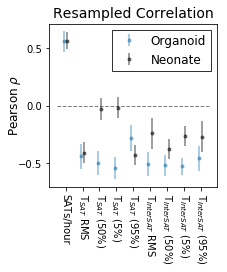

In [61]:
feat_names_abr = [
    'SATs/hour',
    'T$_{SAT}$ RMS',
    'T$_{SAT}$ (50%)',
    'T$_{SAT}$ (5%)',
    'T$_{SAT}$ (95%)',
    'T$_{InterSAT}$ RMS',
    'T$_{InterSAT}$ (50%)',
    'T$_{InterSAT}$ (5%)',
    'T$_{InterSAT}$ (95%)',
]

plt.figure(figsize=(3,3))
plt.errorbar(np.arange(1,10)-0.1, params_org[:,2,:].mean(axis=0), params_org[:,2,:].std(axis=0), ls='none',marker='.',alpha=0.5, label='Organoid')
plt.errorbar(np.arange(1,10)+0.1, params_baby[:,2,:].mean(axis=0), params_baby[:,2,:].std(axis=0), ls='none',marker='.', color='k', alpha=0.5, label='Neonate')
plt.plot(plt.xlim(), [0,0], 'k--',lw=1, alpha=0.5)
#plt.xticks(np.arange(len(rhos))+1)
plt.xticks(np.arange(len(rhos))+1, feat_names_abr, rotation=-90, ha='center')
plt.yticks(np.arange(-0.5,1,0.5))
#plt.xlabel('Feature Number', fontsize=12)
plt.ylabel(r'Pearson $\rho$', fontsize=12,labelpad=-5)
plt.legend(fontsize=12)
plt.title('Resampled Correlation', fontsize=14)
#plt.tight_layout()
plt.savefig(fig_saveout + '6_featcorr.pdf', bbox_inches = 'tight')

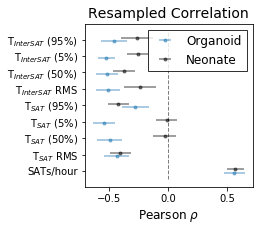

In [66]:
plt.figure(figsize=(3,3))
plt.errorbar(y=np.arange(1,10)-0.1, x=params_org[:,2,:].mean(axis=0), xerr=params_org[:,2,:].std(axis=0), ls='none',marker='.',alpha=0.5, label='Organoid')
plt.errorbar(y=np.arange(1,10)+0.1, x=params_baby[:,2,:].mean(axis=0), xerr=params_baby[:,2,:].std(axis=0), ls='none',marker='.', color='k', alpha=0.5, label='Neonate')
plt.plot([0,0], plt.ylim(), 'k--',lw=1, alpha=0.5)
#plt.xticks(np.arange(len(rhos))+1)
plt.yticks(np.arange(len(rhos))+1, feat_names_abr)
plt.xticks(np.arange(-0.5,1,0.5))
#plt.xlabel('Feature Number', fontsize=12)
plt.xlabel(r'Pearson $\rho$', fontsize=12)
plt.legend(fontsize=12)
plt.title('Resampled Correlation', fontsize=14)
#plt.tight_layout()
plt.savefig(fig_saveout + '6_featcorr_vert.pdf', bbox_inches = 'tight')

### Supplementary: resampled correlation

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


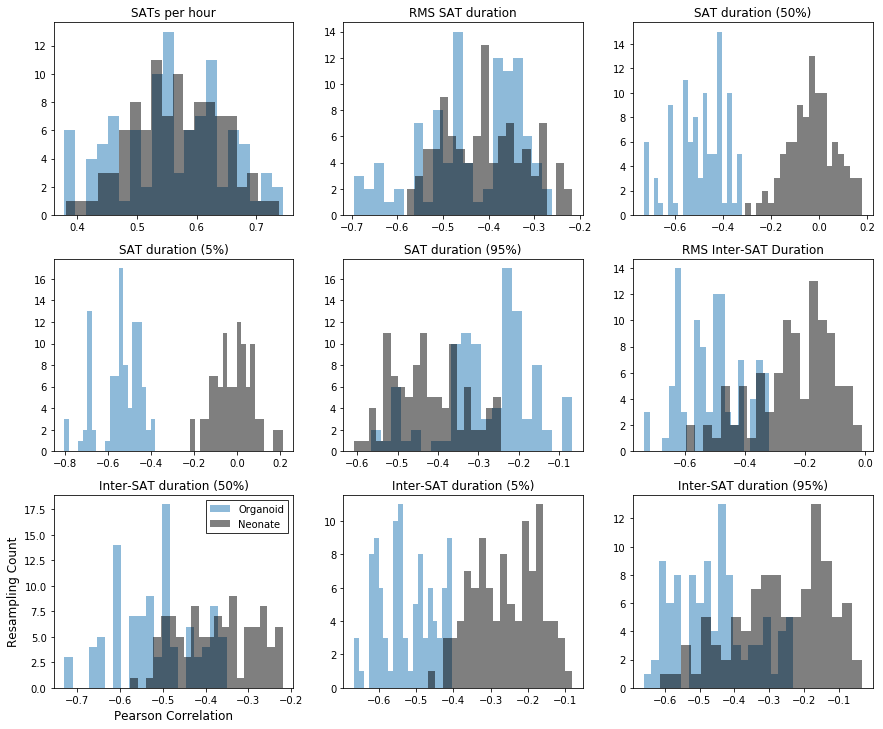

In [71]:
b=2
plt.figure(figsize=(12,10))
for feat in feat_subset:
    plt.subplot(3,3,feat+1)
    plt.hist(params_org[:,b,feat], 20, label='Organoid', alpha=0.5);
    plt.hist(params_baby[:,b,feat], 20, color='k', label='Neonate', alpha=0.5);
    plt.title(feat_names[feat],fontsize=12)

plt.tight_layout()
plt.subplot(3,3,7)
plt.xlabel('Pearson Correlation',fontsize=12)
plt.ylabel('Resampling Count',fontsize=12)
plt.legend()
plt.savefig(fig_saveout + 'supp_resampledcorr.pdf', bbox_inches = 'tight')

Training R2 score: 0.63
---
Mean squared error: 5756.559
R2 score: -63.112
Correlation Coef: -0.51, P-Value: 0.00000


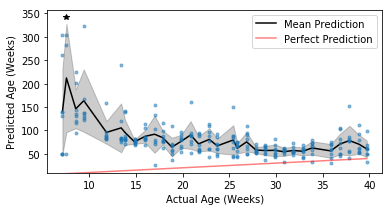

In [9]:
# full features, all ages, baby -> org
brainballbaby_linreg(baby_feat, baby_pma, org_feat_stacked, org_age_stacked, feat_cols)

Training R2 score: 0.71
---
Mean squared error: 34.874
R2 score: -2.902
Correlation Coef: -0.09, P-Value: 0.03200


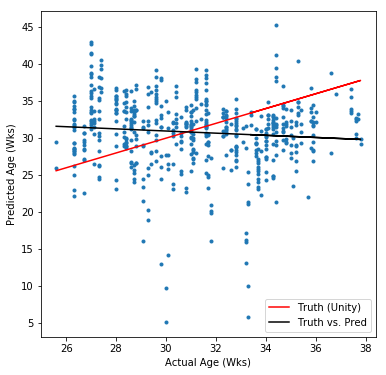

In [6]:
# full features, all ages, org -> baby
brainballbaby_linreg(org_feat_stacked, org_age_stacked, baby_feat, baby_pma, feat_cols)

### restricting age range (25-38 weeks old data only)

Training R2 score: 0.63
---
Mean squared error: 1438.233
R2 score: -89.111
Correlation Coef: -0.00, P-Value: 0.96019


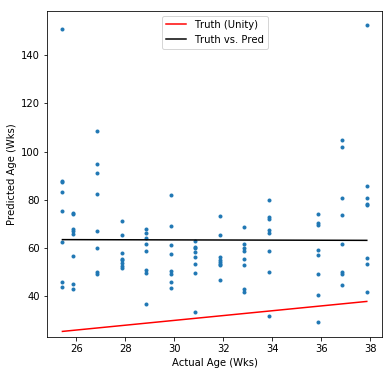

In [7]:
# full features, 25-38wk, baby -> org
brainballbaby_linreg(baby_feat, baby_pma, org_feat_stacked, org_age_stacked, feat_cols, age_range=(25,38))

Training R2 score: 0.44
---
Mean squared error: 36.186
R2 score: -3.048
Correlation Coef: 0.25, P-Value: 0.00000


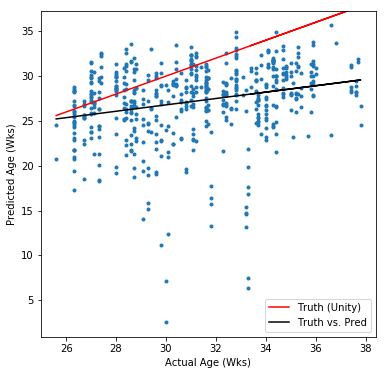

In [8]:
# full features, 25-38wk, org -> baby
brainballbaby_linreg(org_feat_stacked, org_age_stacked, baby_feat, baby_pma, feat_cols, age_range=(25,38))

### restricting features (exclude spectral features)

In [9]:
feat_names

['SATs per hour',
 'RMS SAT duration',
 'SAT duration (50%)',
 'SAT duration (5%)',
 'SAT duration (95%)',
 'RMS Inter-SAT Duration',
 'Inter-SAT duration (50%)',
 'Inter-SAT duration (5%)',
 'Inter-SAT duration (95%)',
 'Relative Delta Power',
 'Relative Theta Power',
 'Relative Alpha Power',
 'Relative Beta Power']

Training R2 score: 0.50
---
Mean squared error: 1006.418
R2 score: -10.209
Correlation Coef: 0.63, P-Value: 0.00000


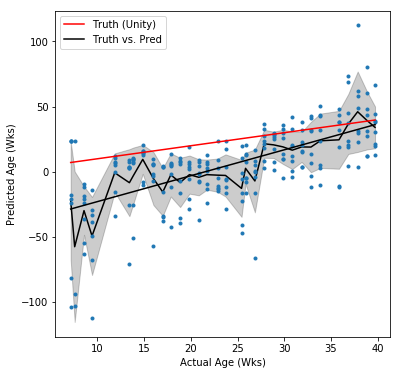

In [107]:
# no spectral features, all ages, baby -> org
brainballbaby_linreg(baby_feat, baby_pma, org_feat_stacked, org_age_stacked, feat_cols[:-4])

Training R2 score: 0.50
---
Mean squared error: 687.294
R2 score: -42.062
Correlation Coef: 0.54, P-Value: 0.00000


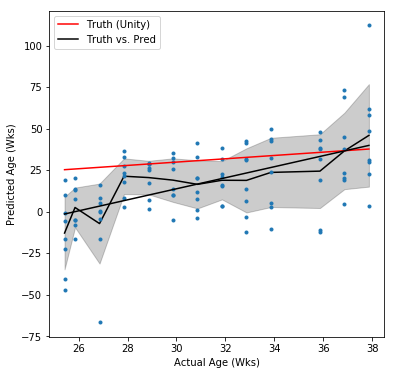

In [113]:
# no spectral features, 25-38wks, baby -> org
brainballbaby_linreg(baby_feat, baby_pma, org_feat_stacked, org_age_stacked, feat_cols[:-4], age_range=(25, 38))

Training R2 score: 0.64
---
Mean squared error: 64.045
R2 score: -6.165
Correlation Coef: 0.17, P-Value: 0.00005


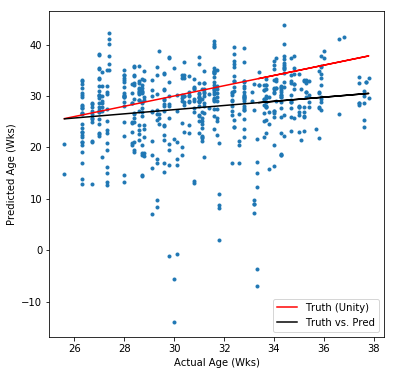

In [12]:
# no spectral features, all ages, org -> baby
brainballbaby_linreg(org_feat_stacked, org_age_stacked, baby_feat, baby_pma, feat_cols[:-4])

Training R2 score: 0.40
---
Mean squared error: 32.492
R2 score: -2.635
Correlation Coef: 0.23, P-Value: 0.00000


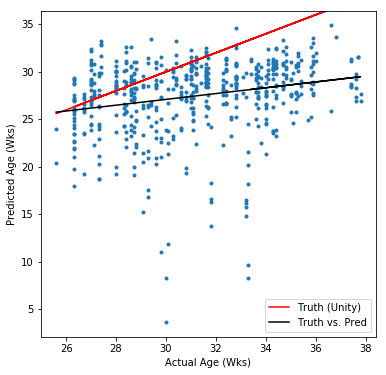

In [14]:
# no spectral features, 25-38wks, org -> baby
brainballbaby_linreg(org_feat_stacked, org_age_stacked, baby_feat, baby_pma, feat_cols[:-4], age_range=(25,38))

### single feature predictor

Training R2 score: 0.28
---
Mean squared error: 8.184
R2 score: 0.084
Correlation Coef: 0.55, P-Value: 0.00000


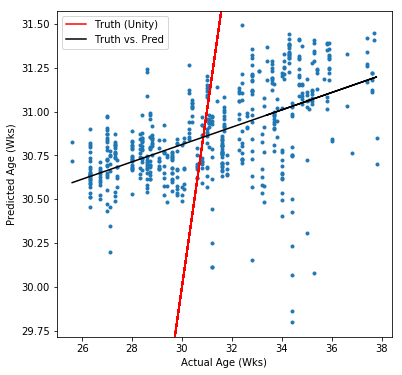

In [15]:
# events per hour, 25-38wks, org -> baby
brainballbaby_linreg(org_feat_stacked, org_age_stacked, baby_feat, baby_pma, feat_cols[[0]], age_range=(25,38))
#plt.ylim([29, 32])

Training R2 score: 0.31
---
Mean squared error: 137.006
R2 score: -7.584
Correlation Coef: 0.53, P-Value: 0.00000


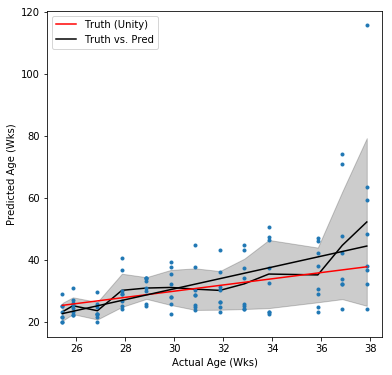

In [109]:
# events per hour, 25-38wks, baby -> org
brainballbaby_linreg(baby_feat, baby_pma, org_feat_stacked, org_age_stacked,  feat_cols[[0]], age_range=(25,38))

### good ol OLS

In [112]:
import statsmodels.api as sm

train_set = 'organoid'
feat_subset = range(len(feat_names))
print('Training on: ' + train_set)

# define training data & id
train_x, train_y, train_id, test_x, test_y, test_id = get_preproc_datasets(
    baby_feat, baby_pma, baby_id, 
    org_feat_stacked, org_age_stacked, org_id_stacked,
    train_set=train_set, feat_cols=feat_cols[feat_subset], age_range=(25,38))

train_x_ = sm.add_constant(train_x) 
smodel = sm.OLS(train_y, train_x_)
results = smodel.fit()
print(results.summary(xname= ['constant'] + feat_names))
print('=====sklearn model======')

model = linear_model.LinearRegression()
model.fit(train_x, train_y)
print('Model R^2 score on training: %.4f' %model.score(train_x,train_y))
print_model_weights(model, np.array(feat_names)[feat_subset])

# # do prediction
# predict_on_testset(model, test_x, test_y)

Training on: organoid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     5.895
Date:                Tue, 06 Mar 2018   Prob (F-statistic):           1.78e-07
Time:                        15:18:09   Log-Likelihood:                -261.71
No. Observations:                 104   AIC:                             549.4
Df Residuals:                      91   BIC:                             583.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
co

### Regularized regression (elastic net)
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#


More specifically, the optimization objective is:
```
1 / (2 * n_samples) * ||y - Xw||^2_2
+ alpha * l1_ratio * ||w||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
```

If you are interested in controlling the L1 and L2 penalty separately, keep in mind that this is equivalent to:
```
a * L1 + b * L2
```
for:
```
alpha = a + b and l1_ratio = a / (a + b).
```

Note on R2 score:


$R^2 = 1- \frac{SS_{pred}}{SS_{bar}}$ , where 

$$ SS_{pred} =  \sum (y_i - \hat{y_i}) $$ and
$$ SS_{bar} =  \sum (y_i - \bar{y_i}) $$


In [27]:
# setting up data
train_set = 'baby'
feat_subset = range(len(feat_names)-4)
#feat_subset = [0,8]
print('Training on: ' + train_set)

# define training data & id
train_x, train_y, train_id, test_x, test_y, test_id = get_preproc_datasets(
    baby_feat, baby_pma, baby_id, 
    org_feat_stacked, org_age_stacked, org_id_stacked,
    train_set=train_set, feat_cols=feat_cols[feat_subset], age_range=(1,40))

# cross-validation iterator
if train_set is 'baby':
    n_splits = 200
    val_size = 0.25
    cv_splitter = model_selection.GroupShuffleSplit(
        n_splits=n_splits, test_size=val_size).split(train_x, train_y, train_id)
elif train_set is 'organoid':
    val_size = 2
    cv_splitter = model_selection.LeavePGroupsOut(
        n_groups=val_size).split(train_x, train_y, train_id)
    

# elastic net
l1_ratios = np.arange(0.01,0.5,0.05)
alphas = np.logspace(-2, 1, 20)
model = linear_model.ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=cv_splitter, normalize=False)

# fit
model.fit(train_x, train_y)
print("Model L1 ratio: %.2f, Model alpha: %.4f" % (model.l1_ratio_, model.alpha_))
print('Model R^2 score on training: %.4f' %model.score(train_x,train_y))
print_model_weights(model, np.array(feat_names)[feat_subset])

Training on: baby
Model L1 ratio: 0.46, Model alpha: 0.0100
Model R^2 score on training: 0.4996
------- Feature Weights: ------
Constant: : 23.08273
SATs per hour: 0.05228
RMS SAT duration: 0.19090
SAT duration (50%): 0.69383
SAT duration (5%): -0.00000
SAT duration (95%): -0.20563
RMS Inter-SAT Duration: 0.92149
Inter-SAT duration (50%): -1.98391
Inter-SAT duration (5%): -0.00000
Inter-SAT duration (95%): -0.20376


---
Mean squared error: 2608.197
R2 score: -28.048
Correlation Coef: 0.65, P-Value: 0.00000


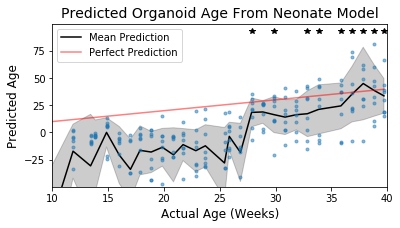

In [29]:
# do prediction
predict_on_testset(model, test_x, test_y, figsize=(6,3))
plt.ylim([-50, 100])
plt.yticks(range(-25,100,25))
plt.xlabel('Actual Age (Weeks)', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.xlim([10, 40])
plt.title('Predicted Organoid Age From Neonate Model', fontsize=14);
plt.savefig(fig_saveout + '6_ageprediction.pdf', bbox_inches = 'tight')

In [92]:
from sklearn import metrics
def corr_pred_test(model, test_y, linfit='OLS'):
    # predict_on_testset(model, test_x, test_y)
    plt.figure(figsize=(10,10))
    pred_y = model.predict(test_x)
    
    if linfit is 'OLS':
        pparams = np.polyfit(pred_y, test_y, deg=1)
        print('OLS weights:', pparams)

    elif linfit is 'RANSAC':
        # fit ransac linear model between actual and predicted age
        rsc = linear_model.RANSACRegressor()
        rsc.fit(X=pred_y.reshape(-1,1), y=test_y)
        pparams = [rsc.estimator_.coef_[0],rsc.estimator_.intercept_]
        print('RANSAC weights:', pparams)

    plt.plot(test_y, pred_y, '.', label='Raw Prediction')
    #plt.plot(test_y, (pred_y-np.mean(pred_y))*24+30, '.', label='Hand Tuned')
    plt.plot(test_y, pred_y*pparams[0]+pparams[1], '.', label='OLS adjusted')
    plt.plot(test_y, test_y, 'r-', label='Ground Truth')
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    #plt.plot(test_y, baby_ema, 'k.', label='EMA')
    plt.legend()
    print('R2 score of scaled-prediction: %.4f' %metrics.r2_score(test_y, pred_y*pparams[0]+pparams[1]))

OLS weights: [  0.13397148  24.82410746]
R2 score of scaled-prediction: 0.4173
Correlation Coef: 0.88, P-Value: 0.00000


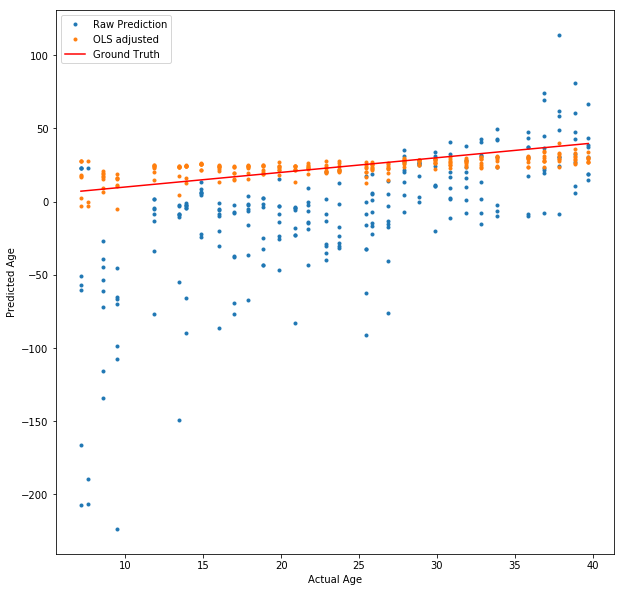

In [93]:
corr_pred_test(model, test_y, 'OLS')
print('Correlation Coef: %.2f, P-Value: %.5f' % sp.stats.pearsonr(baby_pma, baby_ema))

### Elastic net with polynomial features

Training on: organoid


/Users/rdgao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Model L1 ratio: 0.95, Model alpha: 10.0000
Model R^2 score on training: 0.6690
---
Mean squared error: 74.96
R2 score: -7.39
Correlation Coef: 0.41, P-Value: 0.00000


/Users/rdgao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


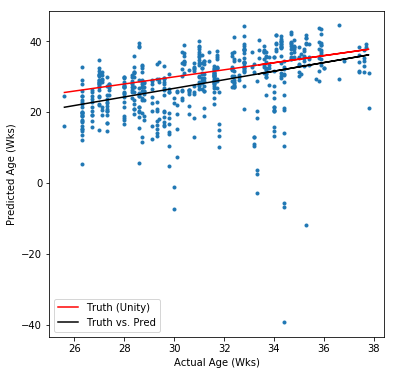

In [117]:
# setting up data
train_set = 'organoid'
feat_subset = range(len(feat_names)-4)
print('Training on: ' + train_set)

# define training data & id
train_x, train_y, train_id, test_x, test_y, test_id = get_preproc_datasets(
    baby_feat, baby_pma, baby_id, 
    org_feat_stacked, org_age_stacked, org_id_stacked,
    train_set=train_set, feat_cols=feat_cols[feat_subset], age_range=(25,38))

# cross-validation iterator
if train_set is 'baby':
    n_splits = 100
    val_size = 0.25
    cv_splitter = model_selection.GroupShuffleSplit(
        n_splits=n_splits, test_size=val_size).split(train_x, train_y, train_id)
elif train_set is 'organoid':
    val_size = 2
    cv_splitter = model_selection.LeavePGroupsOut(
        n_groups=val_size).split(train_x, train_y, train_id)
    

# elastic net
l1_ratios = np.arange(0.05,1,0.05)
alphas = np.logspace(-1, 1, 20)
en_model = linear_model.ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=cv_splitter)

poly_deg = 3
model = make_pipeline(PolynomialFeatures(poly_deg), en_model)
model.fit(train_x, train_y)

# fit
print("Model L1 ratio: %.2f, Model alpha: %.4f" % (model.named_steps['elasticnetcv'].l1_ratio_, 
                                                   model.named_steps['elasticnetcv'].alpha_))
print('Model R^2 score on training: %.4f' %model.score(train_x,train_y))

# do prediction
predict_on_testset(model, test_x, test_y)

### support vector regression

In [130]:
# setting up data
train_set = 'baby'
feat_subset = range(len(feat_names)-4)
print('Training on: ' + train_set)

# define training data & id
train_x, train_y, train_id, test_x, test_y, test_id = get_preproc_datasets(
    baby_feat, baby_pma, baby_id, 
    org_feat_stacked, org_age_stacked, org_id_stacked,
    train_set=train_set, feat_cols=feat_cols[feat_subset], age_range=(25,38))

# cross-validation iterator
if train_set is 'baby':
    n_splits = 100
    val_size = 0.25
    cv_splitter = model_selection.GroupShuffleSplit(
        n_splits=n_splits, test_size=val_size).split(train_x, train_y, train_id)
elif train_set is 'organoid':
    val_size = 2
    cv_splitter = model_selection.LeavePGroupsOut(
        n_groups=val_size).split(train_x, train_y, train_id)

    
SVR_Cs = np.logspace(-2, 2, 20)
SVR_eps = np.logspace(-2, 2, 20)
params = {'C': SVR_Cs, 'epsilon': SVR_eps}
svr_model = svm.SVR()

model = model_selection.GridSearchCV(svr_model, param_grid=params, cv=cv_splitter, return_train_score=False)
model.fit(train_x, train_y)
print('Optimized hyperparams:', model.best_params_)

# do prediction
print('--> Training Data')
predict_on_testset(model, train_x, train_y)
print('--> Test Data')
predict_on_testset(model, test_x, test_y)

Training on: baby


KeyboardInterrupt: 

### gaussian process regression

Training on: baby
--> Training Data
---
Mean squared error: 4.481
R2 score: 0.499
Correlation Coef: 0.71, P-Value: 0.00000
--> Test Data
---
Mean squared error: 851.179
R2 score: -52.330
Correlation Coef: 0.57, P-Value: 0.00000


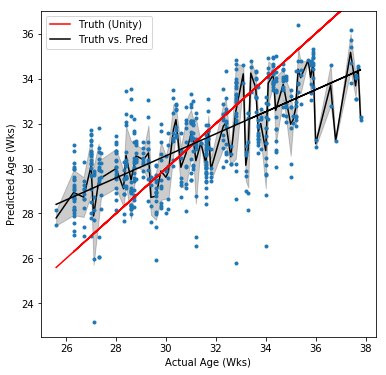

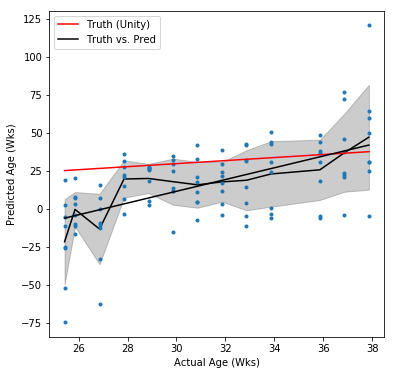

In [185]:
# setting up data
train_set = 'baby'
feat_subset = range(len(feat_names)-4)
#feat_subset = [0]
print('Training on: ' + train_set)

# define training data & id
train_x, train_y, train_id, test_x, test_y, test_id = get_preproc_datasets(
    baby_feat, baby_pma, baby_id, 
    org_feat_stacked, org_age_stacked, org_id_stacked,
    train_set=train_set, feat_cols=feat_cols[feat_subset], age_range=(25,38))

# GPR - single pass

# anisotropic RBF kernel
# ker_len = train_x.std(axis=0)
# gpr_kernel = gaussian_process.kernels.RBF(length_scale=ker_len)

# dot product (linear kernel)
sigma = 30
gpr_kernel = gaussian_process.kernels.DotProduct(sigma_0=sigma)

alpha = 10
model = gaussian_process.GaussianProcessRegressor(kernel=gpr_kernel, alpha=alpha)
model.fit(train_x, train_y)


# plt.figure(figsize=(6,6))
# plt.plot(train_x, train_y, '.')
# x_plt = np.arange(150,300).reshape(-1,1)
y_m, y_std = model.predict(test_x, return_std=True)
# plt.plot(x_plt, y_plt, '.', ms=0.5)
# plt.fill_between(x_plt[:,0], y_plt-y_std, y_plt+y_std)

# do prediction
print('--> Training Data')
predict_on_testset(model, train_x, train_y)
print('--> Test Data')
predict_on_testset(model, test_x, test_y)

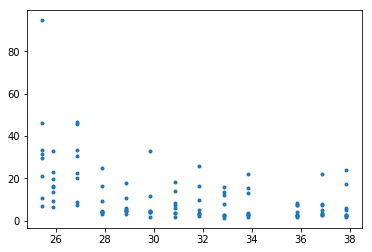

In [190]:
plt.plot(test_y, y_std, '.')

In [ ]:
# GPR with cross validation

Training on: baby
Optimized hyperparams: {'alpha': 0.21544346900318834}
--> Training Data
---
Mean squared error: 4.907
R2 score: 0.451
Correlation Coef: 0.67, P-Value: 0.00000
--> Test Data
---
Mean squared error: 225.891
R2 score: -13.153
Correlation Coef: -0.38, P-Value: 0.00006


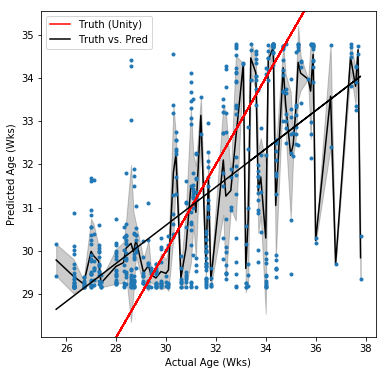

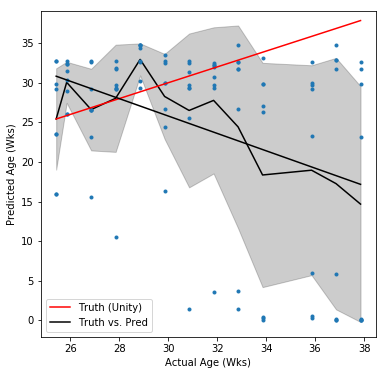

In [182]:
# setting up data
train_set = 'baby'
feat_subset = range(len(feat_names)-4)
#feat_subset = [0]
print('Training on: ' + train_set)

# define training data & id
train_x, train_y, train_id, test_x, test_y, test_id = get_preproc_datasets(
    baby_feat, baby_pma, baby_id, 
    org_feat_stacked, org_age_stacked, org_id_stacked,
    train_set=train_set, feat_cols=feat_cols[feat_subset], age_range=(25,38))

# cross-validation iterator
if train_set is 'baby':
    n_splits = 10
    val_size = 0.25
    cv_splitter = model_selection.GroupShuffleSplit(
        n_splits=n_splits, test_size=val_size).split(train_x, train_y, train_id)
elif train_set is 'organoid':
    val_size = 2
    cv_splitter = model_selection.LeavePGroupsOut(
        n_groups=val_size).split(train_x, train_y, train_id)
    
# GPR - single pass
ker_len = train_x.std(axis=0)
gpr_kernel = gaussian_process.kernels.RBF(length_scale=ker_len)

# sigma = 30
# gpr_kernel = gaussian_process.kernels.DotProduct(sigma_0=sigma)

# alpha = 10
# model = gaussian_process.GaussianProcessRegressor(kernel=gpr_kernel, alpha=alpha)
# model.fit(train_x, train_y)

# GPR cross validation on kernel and alpha
# ker_lens = np.logspace(-2, 2, 10)
# kernels = [gaussian_process.kernels.RBF(length_scale=l) for l in ker_lens]
alphas = np.logspace(-2, 2, 10)
params = {'alpha': alphas}
gpr_model = gaussian_process.GaussianProcessRegressor(kernel=gpr_kernel)
model = model_selection.GridSearchCV(gpr_model, param_grid=params, cv=cv_splitter, return_train_score=False)
model.fit(train_x, train_y)
print('Optimized hyperparams:', model.best_params_)



# plt.figure(figsize=(6,6))
# plt.plot(train_x, train_y, '.')
# x_plt = np.arange(150,300).reshape(-1,1)
# y_plt, y_std = model.predict(x_plt, return_std=True)
# plt.plot(x_plt, y_plt, '.', ms=0.5)
# plt.fill_between(x_plt[:,0], y_plt-y_std, y_plt+y_std)

# do prediction
print('--> Training Data')
predict_on_testset(model, train_x, train_y)
print('--> Test Data')
predict_on_testset(model, test_x, test_y)

### brainball-baby age model
- DONE use only timing features, since relative power is altered by tissue


- DONE primary: since we treat the organoid as a model of development, we build model using organoid data (restrict age to (25-38 wks)) and predict baby age.
    - supp: build model using full organoid age range
    

- DONE leave-p-group-out OR group-k-fold CV to train on training data to select:
    - best model (OLS, elastic net, kernel regression, SVR)
    - hyperparameters
    - note: doesn't make sense here to merge the features from different babies/organoids

- candidate models: 
    - DONE elastic net
    - DONE SVR
    - DONE GP
        - explore GP kernels
    
- supp: feature subset?


- DONE get OLS weights to brad

- train-test problem
- mismatched time point problem

- DONE build model using baby data to predict organoid full age range

- DONE do GP with CV
    - pretty garbage, but we learned that you can build an anisotropic gaussian kernel